# Molecular Cross-Validation for Poisson PCA

In this notebook, we show how to use molecular cross-validation (MCV) to select an optimal number of principal components for Poisson PCA, using Will Townes' [recent implementation](github.com/willtownes/glmpca-py) of generalized PCA.

`glmpca` fits a linear low-rank latent model with a nonlinear link functio, and a Poisson loss. Mathematically, it models a count matrix `Y` as having entries drawn

$Y_{ij} \sim \operatorname{Poisson}(M_{ij}),$

where 

$M = \exp(UV^T + u \mathbf{1}^T + \mathbf{1} v^T)$

is a product of rank-$k$ matrices $U$ and $V$ plus row- and column- offsets $u$ and $v$.

The question is, for which choice of rank $k$ will $M$ be the closest to the underlying distribution from which $Y$ was produced? That is, if in fact $Y \sim \operatorname{Poisson}(Z_{ij})$, for which $k$ will $M$ be closest to $Z$?

We can answer this using MCV.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scanpy as sc

from glmpca import glmpca
from molecular_cross_validation.mcv_sweep import GridSearchMCV
from molecular_cross_validation.util import poisson_fit

In [2]:
def glmpca_denoise(umis, n_components):
    Y = umis.T
    output = glmpca.glmpca(Y, n_components, penalty=1, fam='poi', verbose=True)
    offsets = np.log(Y.mean(0))
    M = np.exp(output['loadings'].dot(output['factors'].T) + output['coefX'] + offsets)
    return M.T

We use the classic PBMC3k dataset from 10X genomics. Since the model needs to be fit once for each number of principal components, a full search on all cells can take a few hours to run.

In [3]:
data = sc.datasets.pbmc3k()
sc.pp.filter_cells(data, min_counts=1000)
sc.pp.filter_genes(data, min_cells=10)
umis = data.X.toarray().astype(int)

We then filter genes based on number of zeros compared to expecation from Poisson. Deviance or (binned) overdispersion would also be reasonable.

In [4]:
poisson_p_val = poisson_fit(umis)

In [5]:
umis = umis[:, poisson_p_val < 0.01]

In [6]:
mcv_search = GridSearchMCV(
    glmpca_denoise,
    data_split=0.9,
    n_splits=1, 
    loss="poisson",
    param_grid={"n_components": np.arange(10, 60, 5)}
)

denoised_umis = mcv_search.fit_transform(umis)

Iteration: 0 | deviance=4.6968E+6
Iteration: 1 | deviance=4.6954E+6
Iteration: 2 | deviance=3.5967E+6
Iteration: 3 | deviance=3.3695E+6
Iteration: 4 | deviance=3.2903E+6
Iteration: 5 | deviance=3.2545E+6
Iteration: 6 | deviance=3.2358E+6
Iteration: 7 | deviance=3.2242E+6
Iteration: 8 | deviance=3.2161E+6
Iteration: 9 | deviance=3.2101E+6
Iteration: 10 | deviance=3.2053E+6
Iteration: 11 | deviance=3.2015E+6
Iteration: 12 | deviance=3.1984E+6
Iteration: 13 | deviance=3.1958E+6
Iteration: 14 | deviance=3.1935E+6
Iteration: 15 | deviance=3.1916E+6
Iteration: 16 | deviance=3.1899E+6
Iteration: 17 | deviance=3.1884E+6
Iteration: 18 | deviance=3.1871E+6
Iteration: 19 | deviance=3.1859E+6
Iteration: 20 | deviance=3.1848E+6
Iteration: 21 | deviance=3.1838E+6
Iteration: 22 | deviance=3.1829E+6
Iteration: 23 | deviance=3.1821E+6
Iteration: 24 | deviance=3.1813E+6
Iteration: 25 | deviance=3.1806E+6
Iteration: 26 | deviance=3.1800E+6
Iteration: 27 | deviance=3.1793E+6
Iteration: 28 | deviance=3.178

Iteration: 34 | deviance=2.7448E+6
Iteration: 35 | deviance=2.7440E+6
Iteration: 36 | deviance=2.7433E+6
Iteration: 37 | deviance=2.7427E+6
Iteration: 38 | deviance=2.7420E+6
Iteration: 39 | deviance=2.7414E+6
Iteration: 40 | deviance=2.7408E+6
Iteration: 41 | deviance=2.7403E+6
Iteration: 42 | deviance=2.7397E+6
Iteration: 43 | deviance=2.7392E+6
Iteration: 44 | deviance=2.7387E+6
Iteration: 45 | deviance=2.7382E+6
Iteration: 46 | deviance=2.7378E+6
Iteration: 47 | deviance=2.7373E+6
Iteration: 48 | deviance=2.7369E+6
Iteration: 49 | deviance=2.7365E+6
Iteration: 50 | deviance=2.7361E+6
Iteration: 51 | deviance=2.7357E+6
Iteration: 52 | deviance=2.7353E+6
Iteration: 53 | deviance=2.7349E+6
Iteration: 54 | deviance=2.7346E+6
Iteration: 55 | deviance=2.7343E+6
Iteration: 56 | deviance=2.7339E+6
Iteration: 57 | deviance=2.7336E+6
Iteration: 58 | deviance=2.7333E+6
Iteration: 59 | deviance=2.7330E+6
Iteration: 60 | deviance=2.7328E+6
Iteration: 61 | deviance=2.7325E+6
Iteration: 0 | devia

Iteration: 65 | deviance=2.5198E+6
Iteration: 66 | deviance=2.5194E+6
Iteration: 67 | deviance=2.5191E+6
Iteration: 68 | deviance=2.5188E+6
Iteration: 69 | deviance=2.5185E+6
Iteration: 70 | deviance=2.5182E+6
Iteration: 71 | deviance=2.5179E+6
Iteration: 72 | deviance=2.5176E+6
Iteration: 73 | deviance=2.5174E+6
Iteration: 74 | deviance=2.5171E+6
Iteration: 75 | deviance=2.5168E+6
Iteration: 0 | deviance=4.6968E+6
Iteration: 1 | deviance=4.6964E+6
Iteration: 2 | deviance=3.3767E+6
Iteration: 3 | deviance=2.8794E+6
Iteration: 4 | deviance=2.7156E+6
Iteration: 5 | deviance=2.6482E+6
Iteration: 6 | deviance=2.6110E+6
Iteration: 7 | deviance=2.5866E+6
Iteration: 8 | deviance=2.5689E+6
Iteration: 9 | deviance=2.5554E+6
Iteration: 10 | deviance=2.5446E+6
Iteration: 11 | deviance=2.5359E+6
Iteration: 12 | deviance=2.5286E+6
Iteration: 13 | deviance=2.5223E+6
Iteration: 14 | deviance=2.5170E+6
Iteration: 15 | deviance=2.5123E+6
Iteration: 16 | deviance=2.5082E+6
Iteration: 17 | deviance=2.504

Iteration: 58 | deviance=2.5903E+6
Iteration: 59 | deviance=2.5899E+6
Iteration: 60 | deviance=2.5895E+6
Iteration: 61 | deviance=2.5892E+6
Iteration: 62 | deviance=2.5888E+6
Iteration: 63 | deviance=2.5885E+6
Iteration: 64 | deviance=2.5881E+6
Iteration: 65 | deviance=2.5878E+6
Iteration: 66 | deviance=2.5875E+6
Iteration: 67 | deviance=2.5872E+6
Iteration: 68 | deviance=2.5869E+6
Iteration: 69 | deviance=2.5866E+6
Iteration: 70 | deviance=2.5863E+6
Iteration: 71 | deviance=2.5860E+6
Iteration: 72 | deviance=2.5857E+6
Iteration: 73 | deviance=2.5855E+6
Iteration: 74 | deviance=2.5852E+6


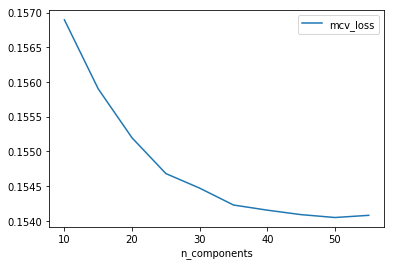

In [7]:
mcv_df = pd.DataFrame(mcv_search.cv_results_)
mcv_df.plot(x='n_components', y='mcv_loss')

In [22]:
mcv_df['n_components'][mcv_df['mcv_loss'].idxmin()]

50

This is more principal components than I would have expected for this relatively simple dataset. It is worth noting that the model fitting may be confounded with model performance. In the output above, one can see that `glmpca` had a higher deviance (2.58e6 > 2.40e6) when 55 PCs were used than when 50 were used, in spite of the model being strictly more flexible. Thus the solver either stopped early or got stuck in a local minimum.

# Compare to PCA on sqrt

We may compare to ordinary PCA on square-root count data. This stabilizes the mean-variance relationship of Poisson noise. However, the model is linear in this sqrt space, unlike `glmpca` which is linear in log space.

In [16]:
import molecular_cross_validation.util as ut
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import mean_squared_error


def pca_sweep(umis, data_split = 0.9, n_trials = 1, true_counts = 5e5, max_components=20, spacing=1, seed=42):

    seed = sum(map(ord, f"biohub_{seed}"))
    random_state = np.random.RandomState(seed)

    k_range = np.arange(1, max_components + 1, spacing)

    mcv_loss = np.empty((n_trials, k_range.shape[0]), dtype=float)

    data_split, data_split_complement, overlap = ut.overlap_correction(
        data_split, umis.sum(1, keepdims=True) / true_counts
    )

    # run n_trials for self-supervised sweep
    for i in range(n_trials):
        umis_X, umis_Y = ut.split_molecules(umis, data_split, overlap, random_state)

        umis_X = np.sqrt(umis_X)
        umis_Y = np.sqrt(umis_Y)

        U, S, V = randomized_svd(umis_X, n_components=max_components)
        US = U.dot(np.diag(S))

        for j, k in enumerate(k_range):
            pca_X = US[:, :k].dot(V[:k, :])
            conv_exp = ut.convert_expectations(pca_X, data_split, data_split_complement)

            mcv_loss[i, j] = mean_squared_error(umis_Y, conv_exp)
    
    return k_range, mcv_loss

In [17]:
k_range, mcv_loss = pca_sweep(umis, max_components=60, spacing=5)

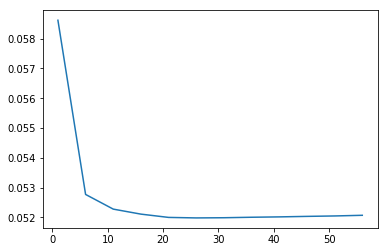

In [18]:
plt.plot(k_range, mcv_loss[0])

In [21]:
k_range[np.argmin(mcv_loss[0])]

26

This model suggests significantly fewer principal components, which may be due to
* the difference in loss
* the difference in model (sqrt-linear vs log-linear)
* the difference in model fitting (glmpca is a local optimization scheme).